# Performance Metrics

## Mean Squared Error (MSE)


$$
\frac{1}{n}\sum^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}
$$

## Root Mean Squared Error (RMSE)


$$
\sqrt{\frac{1}{n}\sum^{n}_{i=1}(y_{i}-\hat{y}_{i})^{2}}
$$

## Mean Absolut Error (MAE)


$$
\frac{1}{n}\sum^{n}_{i=1}|y_{i}-\hat{y}_{i}|
$$

In order to scale MAE to the data, it will often be divided by the data's mean value, to 
arrive at a percentage:

$$
\frac{\frac{1}{n}\sum^{n}_{i=1}|y_{i}-\hat{y}_{i}|}{\bar{y}}
$$


## Mean Absolute Percent Error (MAPE)

Is another very common metric despite its poor 
ability to represent performance of a model. Not to be confused with total MAE divided 
by the mean value, MAPE divides each error by the value of the data point at that error:


$$
\frac{1}{n}\sum^{n}_{i=1} \left | \frac{y_{i}-\hat{y}_{i}}{y_{i}} \right |
$$

## Coverage

Coverage is simply the percentage of actual values 
that lie between the predicted upper and lower uncertainty bounds. By default, the 
uncertainty limits cover 80% of the data, so your coverage value should be 0.8. 

If you find a coverage value that does not equal the interval_width set during 
model instantiation, it means your model is not well calibrated to the uncertainty. In 
practice, this simply means that you probably cannot trust the stated uncertainty intervals 
in the future portions of your forecast and may want to adjust them based upon the 
coverage value.

# Creating the Prophet performance metrics DataFrame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [2]:
URL = 'https://raw.githubusercontent.com/PacktPublishing/Forecasting-Time-Series-Data-with-Facebook-Prophet/main/data/online_retail.csv'

df = pd.read_csv(URL)
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

In [3]:
model = Prophet(yearly_seasonality=4)
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -27.5194


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       2379.45    0.00125648       164.644   1.248e-05       0.001      138  LS failed, Hessian reset 
      96       2379.58   0.000106219       63.7483   1.411e-06       0.001      197  LS failed, Hessian reset 
      99       2379.58   3.63198e-05       52.5391        0.96        0.96      200   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2379.59   1.46984e-05       81.2913   1.866e-07       0.001      296  LS failed, Hessian reset 
     164       2379.59   1.14861e-07       49.3578     0.08598           1      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


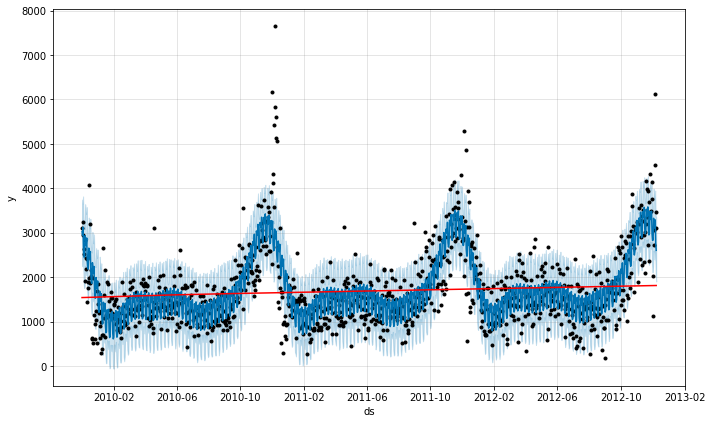

In [4]:
forecast = model.predict()
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

The `performance_metrics` function requires a cross-validation DataFrame as input

In [5]:
df_cv = cross_validation(
    model,
    horizon='90 days',
    period='30 days',
    initial='730 days',
    parallel='processes'
)

INFO:prophet:Making 10 forecasts with cutoffs between 2011-12-14 00:00:00 and 2012-09-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4bd20f4310>


Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.7545
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0658
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1570.36   1.50036e-06       80.4064     0.03345           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       1570.36   6.14819e-08         60.49      0.4813      0.4813      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.4456
    Iter      log prob        ||dx||      ||grad||     

In [9]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-12-15,2801.361915,2066.887677,3553.657878,3702.986147,2011-12-14
1,2011-12-16,2352.472912,1666.506907,3086.701354,1229.263629,2011-12-14
2,2011-12-17,2182.525172,1446.188646,2912.727311,1325.415023,2011-12-14
3,2011-12-18,2165.613157,1460.720268,2850.362888,2739.454215,2011-12-14
4,2011-12-19,2636.302965,1928.768691,3362.787114,2699.823386,2011-12-14


In [6]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,221556.432780,470.697815,379.425616,0.300631,0.232154,0.258435,0.855556
1,10 days,218182.640915,467.100247,375.197067,0.297690,0.222173,0.255993,0.855556
2,11 days,202873.053661,450.414313,368.335784,0.287832,0.201417,0.251034,0.877778
3,12 days,179193.321944,423.312322,350.707385,0.273835,0.207090,0.240925,0.922222
4,13 days,173095.233614,416.047153,344.551126,0.260977,0.191268,0.234275,0.933333


/home/caio-mac/miniconda3/envs/forecast-fb/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/home/caio-mac/miniconda3/envs/forecast-fb/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


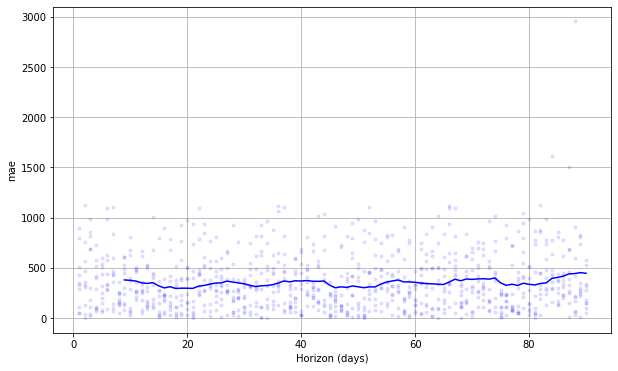

In [7]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

/home/caio-mac/miniconda3/envs/forecast-fb/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/home/caio-mac/miniconda3/envs/forecast-fb/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/home/caio-mac/miniconda3/envs/forecast-fb/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_con

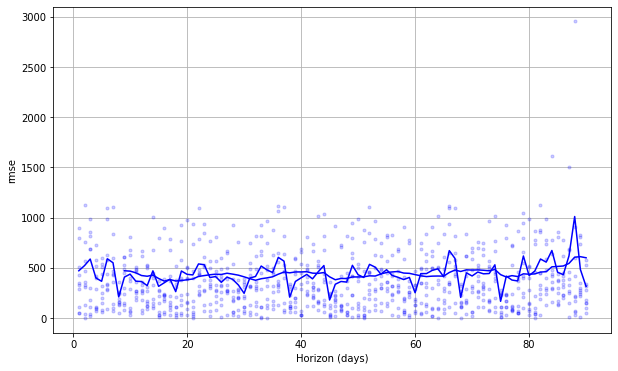

In [8]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=.01,
                             ax=ax)
plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=.1,
                             ax=ax)
plt.show()

# Tuning hyperparameters with grid search

In [16]:
param_grid = {
    'changepoint_prior_scale': [0.5, 0.1, 0.01, 0.001],
    'seasonality_prior_scale': [10.0, 1.0, 0.1, 0.01],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [17]:
import numpy as np
import itertools

all_params = [dict(zip(param_grid.keys(), value))
              for value in itertools.product(*param_grid.values())]
rmse_values= []

In [22]:
for params in all_params:
    model = Prophet(yearly_seasonality=4, **params).fit(df)
    df_cv = cross_validation(model,
                             horizon='30 days',
                             parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmse_values.append(df_p['rmse'].values[0])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b910860a0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2385.45    0.00200957       56.1205       0.487           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2387.27     0.0126211        18.903           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2387.78    0.00029852       8.84618           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2388.21   0.000233663       11.0313           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2388.43   0.000399483       12.8757           1           1      590   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b9111b0d0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2389.75     0.0031231       83.7944      0.3738      0.3738      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2391.44    0.00499537       30.4901           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2391.91    0.00120606       21.3968           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     394       2392.03   5.09828e-05       21.7296   3.641e-06       0.001      520  LS failed, Hessian reset 
     399       2392.05   0.000233157       18.9552      0.6314      0.6314      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2392.1   7.91284e-05    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b91086430>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2385.53    0.00244705       77.2808           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2387.48   0.000832677         12.17           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2388.12   0.000595074       12.9791           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2388.34   0.000460684       10.1183           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2388.6     0.0022893       27.8593           1           1      603   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b9114b310>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2389.38     0.0120935       29.0524           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2390.87   0.000989687       30.1252      0.1823           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2391.4     0.0022281       27.3829           1           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       2391.49   4.91862e-05       22.4805   1.572e-06       0.001      458  LS failed, Hessian reset 
     399       2391.78   0.000879933       20.6623      0.8443      0.8443      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2391.92   0.000986549    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b910b1910>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2385.05    0.00128428       20.6058           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2386.63    0.00192358       41.6061      0.9611      0.9611      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2387.55   0.000933074       31.4401      0.7431      0.7431      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2387.74   0.000604383       32.2885           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     445       2387.79   3.66002e-05       12.6692   1.763e-06       0.001      563  LS failed, Hessian reset 
     497       2387.86   3.93337e-05    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b9113b310>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2376.55    0.00492525       32.0954           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2379.11    0.00865467        41.121      0.6269      0.6269      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2380.56    0.00378607       92.8099           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2380.83    0.00123772         41.43        0.43           1      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     468       2381.16    0.00106007       62.5288   7.877e-05       0.001      632  LS failed, Hessian reset 
     499       2381.28    0.00141465    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b91157fa0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2327.05    0.00255205       97.4386      0.9942      0.9942      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2333.72    0.00946137       174.616           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2336.02     0.0736247       86.4957           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       2336.47   6.91418e-05        19.841   6.036e-06       0.001      399  LS failed, Hessian reset 
     371       2336.99   2.18766e-09        35.477   2.722e-07           1      485   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabili

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b9113b8e0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2119.71      0.016033       140.036           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2146.37      0.108466       227.753           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2169.43     0.0428303       266.747      0.1164           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2176.3     0.0155456       71.4886           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2179.07    0.00287455       52.4653           1           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b910b15b0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       2380.56   0.000435739        92.634   6.223e-06       0.001      139  LS failed, Hessian reset 
      99       2380.69    0.00101073       65.0116           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       2380.84   1.43439e-05       42.3688   3.564e-07       0.001      247  LS failed, Hessian reset 
     172       2380.84   1.05157e-07       32.9613      0.2101      0.6065      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b911358e0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2385.53    0.00506262       63.4423           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       2386.04   2.35645e-07       31.7119      0.1013       0.871      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       782.507     0.0081872       99.6236           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.2386
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b911d5e20>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2380.52   0.000196789        37.664       0.267      0.5957      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2380.65   5.56382e-07       31.5911           1           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       2380.65   6.74122e-08       33.7068      0.1577      0.1577      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.2386
    Iter  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b9113bd60>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2385.43    0.00482366       45.7419           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       2385.72   0.000132522       62.9235    1.62e-06       0.001      170  LS failed, Hessian reset 
     199       2385.89   1.19789e-06       37.7559           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       2385.89   5.54146e-08       33.6884      0.1085      0.4932      318   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        |

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b91147d60>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2379.99     0.0201271       145.737           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       2380.16   1.61503e-05       45.3571   4.501e-07       0.001      285  LS failed, Hessian reset 
     199       2380.16   3.57545e-06        29.743      0.2953           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       2380.16    9.5595e-08       38.8103      0.1253      0.5407      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
      99       782.467   8.5014

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b911528e0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2371.72   4.45336e-05       47.9587      0.5133      0.5133      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       2372.13   0.000142156       72.0703   2.952e-06       0.001      230  LS failed, Hessian reset 
     197       2372.21   7.76968e-06       42.0781   2.137e-07       0.001      340  LS failed, Hessian reset 
     199       2372.21   6.48379e-06       38.0184           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       2372.21   1.52613e-07       31.0713      0.3024      0.3024      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b910d9bb0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2316.73   8.53505e-05       30.7094      0.1907           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2316.73   1.83667e-05       32.0337   8.138e-07       0.001      181  LS failed, Hessian reset 
     162       2316.74   6.23929e-05       36.2613   1.572e-06       0.001      296  LS failed, Hessian reset 
     199       2316.74   5.37112e-07       26.8029      0.4638      0.4638      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       2316.74   4.78651e-07       26.2939      0.2267           1      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b910860a0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2044.54     0.0108617       267.519      0.2416      0.2416      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2054.45   0.000561892       21.9272      0.2457      0.2457      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2058.82   0.000116997       23.2175       0.663       0.663      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310        2058.9   0.000149204       41.7013    2.69e-06       0.001      454  LS failed, Hessian reset 
     399       2059.24    0.00470556       33.6724           1           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2060.66   0.000644652    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b910d90a0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2378.73   1.52692e-05       508.906           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2379.08   0.000408221       512.506   8.773e-07       0.001      179  LS failed, Hessian reset 
     164       2379.35   6.97387e-09       507.537      0.3703           1      250   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       782.005   0.000252928       462.356      0.7485      0.7485      129   
    Iter      log prob        ||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b91147d60>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60        2379.4     0.0017894       489.981   4.604e-06       0.001      116  LS failed, Hessian reset 
      99       2381.62   1.60064e-05       504.866      0.5947      0.5947      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160        2382.1    0.00150535       779.301   1.996e-06       0.001      284  LS failed, Hessian reset 
     199       2383.01   5.54623e-06       494.925           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       2383.03   3.76464e-08       516.521           1           1      392   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b911d57c0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2378.15    0.00069934       462.551    1.27e-06       0.001      144  LS failed, Hessian reset 
      99       2378.28    2.0041e-05       399.499       0.777       0.777      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2379.41   7.32868e-08       442.293      0.2221      0.2221      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       2379.41   6.98855e-09       355.319      0.3655      0.3655      286   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9095
    Iter      log prob        ||

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b911520a0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       2379.47    0.00122388       472.929   2.811e-06       0.001      110  LS failed, Hessian reset 
      99       2381.39   6.22052e-05       441.319      0.2246      0.9145      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2381.47   6.03507e-05       455.471   1.154e-07       0.001      209  LS failed, Hessian reset 
     164        2381.5   7.62908e-09           459      0.2551      0.2551      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b91135fa0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2377.32   0.000631082       382.191   1.247e-06       0.001      145  LS failed, Hessian reset 
      99       2377.55    8.9874e-05       464.353      0.3557           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2378.7   2.07807e-06       514.508      0.2973           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228        2378.7   5.96716e-09       393.278      0.1563      0.1563      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       779.641   0.000629309       504.392      0.1226           

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b9115dd60>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2367.76   0.000526333       502.627      0.4435           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2369.39   2.15459e-07       460.956      0.9255      0.9255      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       2369.39   9.95267e-07        463.18   1.735e-09       0.001      295  LS failed, Hessian reset 
     226        2369.4   3.97189e-08       441.921           1           1      318   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        |

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b910d9970>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82        2314.5   0.000641845       505.919   1.313e-06       0.001      135  LS failed, Hessian reset 
      99       2314.72   1.02592e-05       429.444           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       2315.45   0.000569603       436.371   9.423e-07       0.001      281  LS failed, Hessian reset 
     199       2315.75   2.61704e-06       428.832      0.1934      0.1934      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       2315.77    2.1469e-05       477.772   4.775e-08       0.001      463  LS failed, Hessian reset 
     299       2315.78   3.57065e-07       336.734           1           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b911478e0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1974.66   1.20936e-05       458.036      0.1895      0.1895      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       1974.84   1.72897e-05       506.181   3.426e-08       0.001      218  LS failed, Hessian reset 
     178       1974.85   1.52602e-08       424.947      0.5931      0.5931      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       639.576   0.000491947        231.32   1.429e-06       0.001       98  LS failed, Hessian reset 
Initial

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b91140310>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2321.98   9.63241e-05       3938.34       0.379           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       2355.47    0.00195929       5261.51   3.672e-07       0.001      223  LS failed, Hessian reset 
     199        2375.1   5.73708e-06       5351.39           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       2375.16   8.65186e-09       5264.46      0.7587      0.7587      343   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18.9095             0       375.952       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



Initial log joint probability = -253.016
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.50124             0       380.912       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -256.392
Initial log joint probability = -8.2386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.92698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       741.185    0.00166756       4735.41   3.065e-07       0.001      103  LS failed, Hessian reset 
Iteration  1. Log joint probability =    318.883. Improved by 575.275.
Iteration  1. Log joint probability =    289.961. Improved by 542.977.
      99       752.714   5.92963e-07          4719      0

       1      -15.2147             0       509.791       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
     105       780.351   0.000592291          4713   1.332e-07       0.001      206  LS failed, Hessian reset 

Initial log joint probability = -373.378
Initial log joint probability = -8.04018
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    761.679. Improved by 167.606.
     141       782.674   8.03844e-06        5166.2    1.53e-09       0.001      288  LS failed, Hessian reset 
      99       941.423   7.00373e-06       4977.19       0.744       0.744      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       835.721   1.54674e-05       5201.93      0.6949      0.6949      123   
Iteration  3. Log joint probability =    696.435. Improved

Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  9. Log joint probability =    771.875. Improved by 0.291657.
     200       1317.38   6.45986e-07       5084.45   1.306e-10       0.001      340  LS failed, Hessian reset 
       1      -23.5799             0       725.348       1e-12       0.001       26   


Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Initial log joint probability = -11.2232
     134       1389.65   2.63765e-06       4762.29   5.934e-10       0.001      244  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -555.073
     215       1317.39   8.35478e-09       4945.45      0.2442      0.2442      359   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     161       1389.67   8.27186e-09       4893.12      0.3426      0.3426      279   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  5. Log joint probability =    1034.66. Improved by 2.36693.
Iteration 10. Log joint probability =    782.817. Improved by 0.492686.

Initial log joint probability = -574.721
Iteration 10. Log joint

       1      -32.6239             0       751.419       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 50. Log joint probability =     793.38. Improved by 3.46456e-08.

Initial log joint probability = -597.549
Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 22. Log joint probability =    990.064. Improved by 4.16974.
Iteration 37. Log joint probability =    1044.86. Improved by 3.9249e-08.
       1      -19.9882             0       745.345       1e-12       0.001       28   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Initial log joint probability = -18.5525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 51. Log joint probability =     793.38. Improv

Iteration 23. Log joint probability =    1495.41. Improved by 1.29475e-05.

Initial log joint probability = -598.697
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.6157
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 52. Log joint probability =     793.38. Improved by 3.64968e-08.
Iteration 38. Log joint probability =    1044.86. Improved by 5.73811e-07.
      72       1550.25   7.04319e-05       4713.11   1.574e-08       0.001      131  LS failed, Hessian reset 
Iteration 23. Log joint probability =    990.585. Improved by 0.52098.
Initial log joint probability = -11.7545
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1551.44   1.08181e-06       3957.95      0.7552      0.7552      162   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b9113bfa0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2317.06   3.48823e-06       5583.71      0.2416      0.2416      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2350.14   3.83644e-07       5016.42      0.4225      0.4225      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2350.31   2.82901e-05       4997.46   5.633e-09       0.001      322  LS failed, Hessian reset 
     272       2350.45   9.15721e-09       4987.89       0.403       0.403      397   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.9095


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18.9095             0       375.504       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
       1      -8.50124             0       378.919       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Initial log joint probability = -8.2386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -253.016

Initial log joint probability = -256.392
Initial log joint probability = -7.92698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99  

Initial log joint probability = -15.2147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -15.2147             0       508.412       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
      99       660.967   5.49732e-07       5653.85       0.299       0.299      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       722.115   7.26655e-08       4960.52   1.397e-11       0.001      287  LS failed, Hessian reset 
     163       722.116   3.29565e-09       4416.47      0.5833      0.5833      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance

Initial log joint probability = -373.378
      56       690.797    0.00132383       4791.12   2.969e-07       0.001      104  LS failed, Hessian reset 
      99       726.869  

Initial log joint probability = -17.7164
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       1130.08    0.00114297       5027.34   2.381e-07       0.001       84  LS failed, Hessian reset 
     186       1126.15   7.66928e-08       5031.64   1.528e-11       0.001      312  LS failed, Hessian reset 
      99       1126.89   0.000102879       4517.79           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       1126.15   9.80557e-09       4958.01      0.6164      0.6164      315   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
       1      -17.7164             0       702.444       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  8. Log joint probability =    774.663. Improved by 6.63

     110       1222.28    8.4812e-09       4959.18      0.4781      0.4781      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
       1      -23.5799             0       724.398       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -555.073
Iteration  5. Log joint probability =    985.867. Improved by 242.493.
      99       1268.68   3.30819e-05       5291.24      0.2666           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       1170.66     0.0056276       5097.25   1.206e-06       0.001      197  LS failed, Hessian reset 
      99       1188.05   0.000931039       4858.43       0.588       0.588      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  9. Log 

Iteration 44. Log joint probability =    781.764. Improved by 1.06414e-06.
Iteration 43. Log joint probability =    590.228. Improved by 4.11529e-07.
Initial log joint probability = -32.6239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -32.6239             0       750.636       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 30. Log joint probability =    1047.44. Improved by 0.00030188.

Initial log joint probability = -597.549
Iteration 13. Log joint probability =    1495.84. Improved by 0.00869162.
Iteration 45. Log joint probability =    781.764. Improved by 5.61574e-07.Iteration 13. Log joint probability =    1524.48. Improved by 0.00259628.

Iteration 31. Log joint probability =    1047.44. Improved by 0.00018902.
Iteration 46. Log joint probability =    781.764. Improved by 5.71713e-08.
Iteration 44. Log joi

       1      -19.9882             0       744.361       1e-12       0.001       28   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  2. Log joint probability =    777.345. Improved by 260.209.
Iteration 48. Log joint probability =    781.764. Improved by 4.49445e-08.

Initial log joint probability = -598.697
Iteration 45. Log joint probability =    590.228. Improved by 8.73383e-07.Iteration 33. Log joint probability =    1047.44. Improved by 1.48159e-05.

Iteration 49. Log joint probability =    781.764. Improved by 1.23165e-07.
Iteration  3. Log joint probability =    937.418. Improved by 160.073.
Iteration 34. Log joint probability =    1047.44. Improved by 1.87759e-05.
Iteration  1. Log joint probability =    324.607. Improved by 923.304.
Iteration 15. Log joint probability =    1495.87. Improved by 0.00735549.
Initial log joint probability = -18.5525
    Iter      log prob        ||dx||      ||gra

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4bd1e470d0>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2320.16   1.89773e-05        4096.1       0.577       0.577      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       2355.24    0.00155001       4956.21   3.124e-07       0.001      247  LS failed, Hessian reset 
     199       2373.35   1.66068e-05       4905.39      0.6156      0.6156      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       2373.51   8.90241e-09        5079.7      0.5486      0.5486      351   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.9095


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18.9095             0       375.952       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
       1      -8.50124             0       380.912       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -224.156
Initial log joint probability = -8.2386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -220.78
Initial log joint probability = -7.92698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56   

       1      -15.2147             0       509.791       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
     199       938.367    2.1252e-05       5021.83           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes Iteration  3. Log joint probability =    703.138. Improved by 200.411.

      99       1060.37   0.000367636       4708.02      0.5559      0.5559      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -341.142
Iteration  4. Log joint probability =    693.431. Improved by 38.1633.
Initial log joint probability = -8.52032
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       942.229    0.00107059       4892.98           1           1      118   
    Iter      log prob        


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
       1      -17.7164             0        703.46       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  9. Log joint probability =    782.067. Improved by 0.50489.
     179       1384.28   7.72495e-07       4694.28   1.573e-10       0.001      255  LS failed, Hessian reset 

Initial log joint probability = -522.837
     199       1384.29   2.96267e-08       4716.89      0.6775      0.6775      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       1384.29   6.02162e-09       4865.42      0.5847      0.5847      281   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  5. Log joint probability =    1033.93. Improved by 15.7693.
Iteration 10. Log jo


Initial log joint probability = -542.484
Iteration 12. Log joint probability =    783.258. Improved by 0.151949.
Iteration  7. Log joint probability =    1035.59. Improved by 1.40902.
Iteration  2. Log joint probability =    1018.97. Improved by 409.525.
Iteration 12. Log joint probability =    792.048. Improved by 1.13767.
Iteration 13. Log joint probability =    783.324. Improved by 0.0662728.
     199        1461.9   4.99322e-06       4792.64      0.3237           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  8. Log joint probability =    1042.91. Improved by 7.31556.
Iteration 14. Log joint probability =    783.344. Improved by 0.0195113.
     246       1461.95   2.00801e-07       5041.97   4.124e-11       0.001      347  LS failed, Hessian reset 
Iteration  3. Log joint probability =    1381.16. Improved by 362.195.
     255       1461.95    7.9466e-09       4707.02      0.4819      0.4819      359   
Optimiza

Initial log joint probability = -32.6239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 30. Log joint probability =    1044.86. Improved by 7.59982e-05.
       1      -32.6239             0       751.419       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -565.313
Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.9882             0       745.345       1e-12       0.001       28   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 42. Log joint probability =    793.367. Improved by 3.60539e-06.


Iteration 23. Log joint probability =    1495.41. Improved by 0.000203148.

Initial log joint probability = -566.461
Iteration 18. Log joint probability =    955.705. Improved by 1.96197.
Iteration 31. Log joint probability =    1044.86. Improved by 2.77152e-05.
Iteration 43. Log joint probability =    793.367. Improved by 5.25098e-08.
Iteration  1. Log joint probability =    586.277. Improved by 1151.59.
Initial log joint probability = -18.5525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 24. Log joint probability =    1495.41. Improved by 7.54845e-05.
Iteration 19. Log joint probability =    967.127. Improved by 11.4221.
      60       1550.49   0.000184031       5000.66   4.078e-08       0.001      119  LS failed, Hessian reset 
Iteration 32. Log joint probability =    1044.86. Improved by 1.7239

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4c0c2b0100>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2316.21   7.75674e-05       5037.21           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2353.18   1.22261e-07       4495.06           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2353.18   2.47655e-07       5040.33   4.805e-11       0.001      298  LS failed, Hessian reset 
     220       2353.18   7.00059e-09       4620.53      0.2085      0.2085      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18.9095             0       375.504       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -220.78


Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.2386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.50124             0       378.919       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -224.156
Initial log joint probability = -7.92698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       561.969   4.36695e-05       5237.14           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.95725
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =   

     126       722.426   7.50199e-09       4443.04      0.3161           1      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
       1      -15.2147             0       508.412       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  3. Log joint probability =      463.6. Improved by 57.5311.
      90       685.068   9.20475e-09       4638.75       0.793       0.793      115   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.4587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.04018
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -341.142
Iteration  3. Log joint probab

Iteration  4. Log joint probability =    710.732. Improved by 205.496.       1      -17.7164             0       702.444       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
     133       1343.06    0.00216897       5220.93   4.539e-07       0.001      199  LS failed, Hessian reset 
Iteration  9. Log joint probability =    778.649. Improved by 22.8611.


Initial log joint probability = -522.837
     169       1345.96   6.77903e-09       4079.29      0.3225      0.3225      213   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 10. Log joint probability =    770.057. Improved by 7.23431.
     199       1241.08    0.00345546       4449.94       0.231           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 10. Log joint probability =    779.262. Impro

      84       1221.29    0.00727129        4753.9   1.326e-06       0.001      163  LS failed, Hessian reset 
      99       1250.15   0.000305086       5266.52      0.7751      0.7751      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -542.484
Iteration 12. Log joint probability =    780.714. Improved by 0.796771.
Iteration  6. Log joint probability =     1008.9. Improved by 187.526.
Iteration 12. Log joint probability =    789.077. Improved by 16.705.
     149       1252.71   2.97993e-05       4889.89   6.126e-09       0.001      277  LS failed, Hessian reset 
Iteration 13. Log joint probability =     781.08. Improved by 0.36546.
Iteration  2. Log joint probability =    1005.66. Improved by 487.765.
Iteration 13. Log joint probability =    791.334. Improved by 2.25679.
     199       1252.86   2.88092e-07       4337.92      0.7826      0.7826      341   
    Iter      log prob        ||dx||      ||

Iteration 21. Log joint probability =    1523.93. Improved by 0.0174427.
Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 54. Log joint probability =    794.378. Improved by 0.00294078.
       1      -19.9882             0       744.361       1e-12       0.001       28   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -565.313
Iteration 25. Log joint probability =     1496.5. Improved by 0.00116703.
Iteration 56. Log joint probability =    781.603. Improved by 6.50748e-08.

Initial log joint probability = -566.461
Iteration 41. Log joint probability =    1047.31. Improved by 1.76286e-06.
Initial log joint probability = -18.5525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 55. Log joint probability =    794.378. Improved by 0.0006221

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4c0c2b0220>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2313.02     5.142e-07       4262.94      0.6835      0.6835      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       2340.01    0.00320099       4571.16   6.437e-07       0.001      230  LS failed, Hessian reset 
     199       2367.87   1.56434e-07       4682.41           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       2367.87   8.07872e-09       4499.33         0.3         0.3      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.9095


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18.9095             0       375.952       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -188.544
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.50124             0       380.912       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



Initial log joint probability = -191.92
Initial log joint probability = -8.2386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.92698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       724.202   9.30456e-09       4784.86      0.3656      0.3656       96   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =     387.06. Improved by 578.98.
Iteration  1. Log joint probability =    278.225. Improved by 466.769.
Initial log joint probability = -7.95725
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.43504
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       759.517   2.27351e-05       4728.42   4.293e-09       0.001      153  LS failed,


Initial log joint probability = -308.906
     133       834.964   7.55056e-09       4645.46      0.1323      0.1323      243   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       943.446   0.000416755       5122.77           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  5. Log joint probability =    790.055. Improved by 7.43632.
      99       1019.12   3.73111e-06       4685.79      0.5386           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       859.342   3.78005e-05       5038.91   7.953e-09       0.001      145  LS failed, Hessian reset 
      99       859.494   1.43025e-06       3362.01           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1060.05   1.15036e-05       5209

Iteration  5. Log joint probability =     1033.9. Improved by 1.81182.
Initial log joint probability = -23.5799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 11. Log joint probability =    792.436. Improved by 0.000749525.
     152       1363.47   6.32608e-05       5177.65   1.279e-08       0.001      276  LS failed, Hessian reset 
       1      -23.5799             0       725.348       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -490.601


     144       1393.11   6.60213e-05       4874.55   1.183e-08       0.001      224  LS failed, Hessian reset 
     145       1421.18     0.0035201       4761.95    7.05e-07       0.001      240  LS failed, Hessian reset 
Iteration 10. Log joint probability =    781.664. Improved by 21.1667.

Initial log joint probability = -510.248
     192       1364.44   2.50117e-06       5147.17   4.737e-10       0.001      367  LS failed, Hessian reset 
Iteration  6. Log joint probability =    1043.34. Improved by 9.44372.
     199       1364.45    2.8981e-07       5215.83       0.406       0.406      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 12. Log joint probability =    792.439. Improved by 0.00230285.
     180       1393.32   1.79393e-07       4439.74   4.137e-11       0.001      309  LS failed, Hessian reset 
     199       1436.18    4.1755e-05       4984.63      0.9336      0.9336      306   
    Iter      log prob        ||

Iteration 50. Log joint probability =    792.492. Improved by 0.00194847.
       1      -32.6239             0       751.419       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -533.076
Iteration 51. Log joint probability =    792.493. Improved by 0.000691108.
Iteration 20. Log joint probability =     1494.8. Improved by 0.000275876.
Iteration 34. Log joint probability =     1044.2. Improved by 4.27635e-07.
Iteration 21. Log joint probability =    1523.29. Improved by 0.0174689.
Iteration 52. Log joint probability =    792.495. Improved by 0.00194058.
Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 35. Log joint probability =     1044.2. Improved by 4.35038e-07.
       1      -19.9882             0       745.345       1e-12       0.001       28   
Optimizat

Iteration 53. Log joint probability =    792.496. Improved by 0.000673375.
Iteration 21. Log joint probability =    1494.81. Improved by 0.00931832.

Initial log joint probability = -534.225
Iteration 22. Log joint probability =    1523.29. Improved by 0.00880681.
Initial log joint probability = -18.5525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 54. Log joint probability =    792.498. Improved by 0.0019441.
Iteration  1. Log joint probability =     584.93. Improved by 1118.01.
Iteration 36. Log joint probability =     1044.2. Improved by 5.28968e-07.
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 55. Log joint probability =    792.498. Improved by 0.00064349.
      99       1560.31      0.018659       4974.35           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b91152d60>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       2316.43    0.00358791       4701.46   6.062e-07       0.001       98  LS failed, Hessian reset 
      99       2334.96    0.00393531       5083.93           1           1      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2346.53   1.27238e-07       4531.13           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       2346.54    9.1775e-09          4492      0.2898           1      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18.9095             0       375.504       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
       1      -8.50124             0       378.919       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -188.544

Initial log joint probability = -191.92
Initial log joint probability = -8.2386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.92698
    Iter      log prob        ||dx||      ||grad||       alpha

       1      -15.2147             0       508.412       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
      99       704.564   1.33049e-05       4952.99           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -308.906
Initial log joint probability = -8.52032
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       722.006   2.49596e-06       4555.27       0.803       0.803      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       704.604   8.60406e-09       5116.48      0.7636      0.7636      165   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.9613
    Iter      log prob     

Iteration  8. Log joint probability =    768.671. Improved by 0.647928.
      99       1318.99    0.00253071       5208.61      0.3972       0.937      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -490.601
Iteration  9. Log joint probability =    783.749. Improved by 0.139746.
     139       1249.26   1.48724e-06       4699.44   2.913e-10       0.001      257  LS failed, Hessian reset 
Iteration  5. Log joint probability =    1014.82. Improved by 11.0902.
       1      -23.5799             0       724.398       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
     159       1249.27   8.49989e-09       4958.75      0.2688      0.2688      283   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance



Initial log joint probability = -510.248
     152       1337.74   2.43295e-06       4954.88   4.633e-10       0.001      222  LS failed, Hessian reset 
Iteration 10. Log joint probability =    784.082. Improved by 0.333475.
Iteration  9. Log joint probability =    771.012. Improved by 2.34096.
     168       1337.74   3.70503e-09       4442.88      0.2754      0.2754      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  6. Log joint probability =    1030.56. Improved by 15.746.
Iteration 11. Log joint probability =    784.189. Improved by 0.106511.
Iteration 10. Log joint probability =    771.178. Improved by 0.165591.
Iteration  7. Log joint probability =    1031.11. Improved by 0.547479.
Iteration 12. Log joint probability =    784.328. Improved by 0.138866.
Iteration  1. Log joint probability =      534.5. Improved by 1025.1.
Iteration 13. Log joint probability =    784.413. Improved by 0.0854164.
Iteration  

Iteration 39. Log joint probability =    1033.77. Improved by 1.40898e-06.
Initial log joint probability = -32.6239
Iteration 50. Log joint probability =    784.583. Improved by 6.45707e-09.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 40. Log joint probability =    772.419. Improved by 3.43245e-06.
       1      -32.6239             0       750.636       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes Iteration 20. Log joint probability =    1483.27. Improved by 0.0442876.

Iteration 40. Log joint probability =    1033.77. Improved by 1.42998e-06.
       1      -19.9882             0       744.361       1e-12       0.001       28   
Optimization terminated with error: 
  Line search failed to achie

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4b9115dd60>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2310.21    0.00209503       4691.85      0.2364           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2314.33   2.10819e-08        5024.6      0.2577           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       2314.33   7.89706e-08       5018.04   1.571e-11       0.001      310  LS failed, Hessian reset 
     221       2314.33    7.1858e-09        4987.3      0.6249      0.6249      323   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18.9095             0       375.952       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -156.308
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.50124             0       380.912       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



Initial log joint probability = -159.684
Initial log joint probability = -8.2386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    144.491. Improved by 300.799.
Initial log joint probability = -7.92698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.95725
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       675.157   7.50215e-05       5077.26   1.626e-08       0.001      109  LS failed, Hessian reset 
Iteration  1. Log joint probability =   -6.95315. Improved by 152.731.
      99       675.964   1.04742e-06       5000.43           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    502.672. Improved by 358.182.
Initial log joint probability = -8.43504
    Iter      lo

       1      -15.2147             0       509.791       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -276.67
      99       839.712     0.0149752       5248.63           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       841.174   2.38277e-07       5032.03      0.2791      0.2791      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.4587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       841.176   2.51822e-09       4585.07      0.2436      0.2436      263   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  4. Log joint probability =     721.67. Improved by 52.6281

Iteration  5. Log joint probability =    973.992. Improved by 2.89903.
Initial log joint probability = -17.7164
Initial log joint probability = -478.012
     108       1349.93   0.000197845       4885.11   4.253e-08       0.001      217  LS failed, Hessian reset 

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       1405.11   7.47897e-07       5030.54   1.485e-10       0.001      191  LS failed, Hessian reset 
     199       1314.19   9.13586e-07       5050.31      0.4363           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       1405.11   8.19299e-09       5046.65      0.2129      0.7189      216   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     239       1183.17   1.11713e-05       5040.87   2.239e-09       0.001      386  LS failed, Hessian reset 
       1      -17.7164             0        703.46

Iteration 11. Log joint probability =    728.288. Improved by 0.0783558.
Iteration  6. Log joint probability =    987.839. Improved by 13.8473.

Initial log joint probability = -458.364
Iteration 12. Log joint probability =    728.338. Improved by 0.0491543.
Iteration  7. Log joint probability =    991.133. Improved by 3.29467.
Iteration 13. Log joint probability =    707.641. Improved by 2.07281.
Iteration  1. Log joint probability =    575.995. Improved by 1054.01.
Iteration 13. Log joint probability =    728.371. Improved by 0.0337089.
Iteration  1. Log joint probability =    537.844. Improved by 996.208.
Iteration 14. Log joint probability =    708.552. Improved by 0.911876.
Iteration  8. Log joint probability =     991.33. Improved by 0.196746.
Iteration 14. Log joint probability =    728.403. Improved by 0.0314773.
Iteration 15. Log joint probability =    728.415. Improved by 0.0120991.
Iteration  9. Log joint probability =    991.576. Improved by 0.245406.
Iteration 15. Log join

       1      -32.6239             0       751.419       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 49. Log joint probability =    753.026. Improved by 2.42926e-05.
Iteration 23. Log joint probability =    1442.55. Improved by 0.00292938.

Initial log joint probability = -500.84
Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


Iteration 36. Log joint probability =    991.926. Improved by 1.0757e-06.
Iteration 50. Log joint probability =    753.026. Improved by 6.71686e-05.
       1      -19.9882             0       745.345       1e-12       0.001       28   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -18.5525
Initial log joint probability = -501.989
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 17. Log joint probability =    1470.39. Improved by 5.88438e-07.
Iteration 24. Log joint probability =    1442.56. Improved by 0.00280715.
Iteration 51. Log joint probability =    753.026. Improved by 3.46311e-05.
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    487.403. Improved by 988.243.
Iteration 37. Log joint probability =   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 48 forecasts with cutoffs between 2010-12-04 00:00:00 and 2012-11-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f4c0c2b0220>


Initial log joint probability = -27.5194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46        1896.4    0.00129422       4789.86    2.71e-07       0.001       92  LS failed, Hessian reset 
      99        1901.6   0.000509391       4955.35           1           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       1908.08    0.00109598       5001.91    2.11e-07       0.001      208  LS failed, Hessian reset 
     199       1924.94   0.000115203       5208.92      0.7034      0.7034      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       1941.12   8.22906e-06       5133.14   1.881e-09       0.001      445  LS failed, Hessian reset 
     299       1941.26    1.4263e-06       5198.19      0.3034           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Initial log joint probability = -18.9095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18.9095             0       375.504       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -156.308
Initial log joint probability = -8.50124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -8.50124             0       378.919       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made



Initial log joint probability = -159.684
Initial log joint probability = -8.2386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.92698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  1. Log joint probability =    135.978. Improved by 292.286.
Initial log joint probability = -7.95725
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       580.573   2.36392e-08       4377.49      0.6053      0.6053      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       580.573   9.42115e-09       4726.87           1           1      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =     260.21. Improved by 419.894.
      99       611.627   5.28309e-07       5045

      99       648.056    0.00153898        4843.3       1.243       0.233      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.2147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -15.2147             0       508.412       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  3. Log joint probability =    628.319. Improved by 23.4938.
      99       716.443   2.97622e-07       4958.14     0.05283           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -276.67
     156       704.422   9.37964e-08       4918.02   1.902e-11       0.001      250  LS failed, Hessian reset 
     125       716.449   8.87492e-09       4800.72      0.2395      0.7714    


Initial log joint probability = -478.012

Initial log joint probability = -458.364
      97       1101.94   6.00891e-07        5159.3   1.277e-10       0.001      164  LS failed, Hessian reset 
      99       1101.94   2.70797e-07       4008.61           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  5. Log joint probability =    867.618. Improved by 11.1586.
     113       1101.94   8.38764e-09       4440.15      0.8154      0.8154      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 10. Log joint probability =    665.316. Improved by 3.59442.
     199       1092.83    0.00213365       5013.95      0.1968           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       1156.07    0.00238643       5140.09   4.677e-07       0.001      163  LS failed, Hessian reset 
It

Initial log joint probability = -32.6239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 23. Log joint probability =    1289.99. Improved by 0.0828044.
       1      -32.6239             0       750.636       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 37. Log joint probability =    873.343. Improved by 1.85629e-05.

Initial log joint probability = -500.84
Iteration 25. Log joint probability =    1275.33. Improved by 3.92167e-05.


Iteration 52. Log joint probability =    671.866. Improved by 7.90931e-09.
Initial log joint probability = -19.9882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -19.9882             0       744.361       1e-12       0.001       28   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 38. Log joint probability =    873.343. Improved by 8.11912e-06.

Initial log joint probability = -501.989
Iteration 24. Log joint probability =    1290.01. Improved by 0.0285982.
Iteration  1. Log joint probability =    475.696. Improved by 976.536.
Initial log joint probability = -18.5525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 39. Log joint probability =    873.343. Improve

In [23]:
results = pd.DataFrame(all_params)
results['rmse'] = rmse_values
results.head()

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
0,0.5,10.0,additive,800.404477
1,0.5,10.0,multiplicative,921.737432
2,0.5,1.0,additive,791.398087
3,0.5,1.0,multiplicative,892.352944
4,0.5,0.1,additive,753.461977


In [28]:
best_params = all_params[np.argmin(rmse_values)]
print(min(rmse_values))
print(best_params)

564.5825297932428
{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}
